<html>
<head>
	<title></title>
</head>
<body>
<h2 style="text-align: center;line-height: 120%;">ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ ВЫСШЕГО ОБРАЗОВАНИЯ НАЦИОНАЛЬНЫЙ ИССЛЕДОВАТЕЛЬСКИЙ УНИВЕРСИТЕТ «МОСКОВСКИЙ ЭНЕРГЕТИЧЕСКИЙ ИНСТИТУТ» Кафедра «РЗиАЭ»</h2>
<h2 style="text-align: center;line-height: 20%;">Лабораторная работа №2</h2>

<h3 style="text-align: center;line-height: 80%;"><em>Наивный Байесовский классификатор. Метод опорных векторов.</em></h3>

<p style="text-align: right;line-height: 40%;">Выполнил: студент группы Э-13м-19</p>

<p style="text-align: right;line-height: 40%;">Шмыков А.Д.</p>

<p style="text-align: right;line-height: 40%;">Проверил: Нухулов С.М.</p>
<h4 style="text-align: center;line-height: 100%;"><em> Москва, 2020</em></h3>
</body>
</html>

<h3> П1. Импорт библиотек, загрузка анализируемых данных csv и написание функций для вывода графиков. </h3>

In [109]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc 
from sklearn.svm import SVC 
from sklearn.metrics import roc_curve 
from sklearn.metrics import confusion_matrix 
from sklearn import metrics 
from sklearn.naive_bayes import MultinomialNB 
from sklearn import model_selection 
from collections import Counter 
from sklearn import feature_extraction 
data=pd.read_csv(r"C:\Users\1\Downloads\spam.csv", encoding = 'latin1')
#Удаление ненужных столбцов
data=data.drop(columns=['Unnamed: 2', 'Unnamed: 3','Unnamed: 4'])
data = data.rename(columns={'v1': 'target', 'v2': 'text'})
data.head(5)
# X=data.drop(columns=['target'])
# y=data['target']
# y.head(5)

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<h3> П2. Построить круговую диаграмму для принимаемых значений целевой переменной. </h3>

Text(0.5, 1.0, 'Диаграмма целевой переменной')

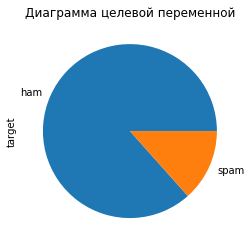

In [110]:
target = pd.value_counts(data['target']) 
target.plot(kind = 'pie') 
plt.title('Диаграмма целевой переменной') 

<h3> П3. Построить столбиковую диаграмму для двадцати наиболее часто встречающихся слов в обоих классах.</h3>

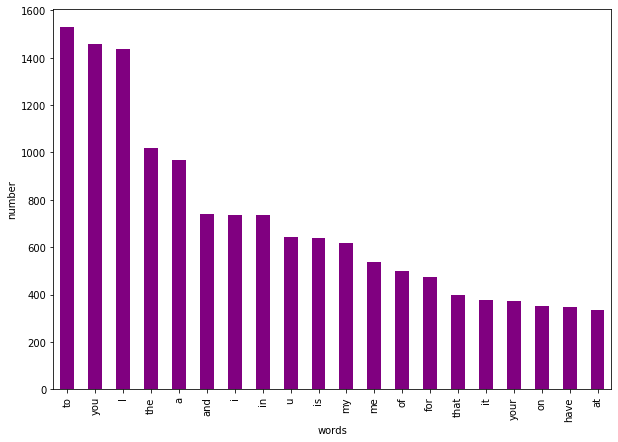

In [111]:
ham_words = Counter(" ".join(data[data['target']=='ham']["text"]).split()).most_common(20)
df_ham_words = pd.DataFrame.from_dict(ham_words)
df_ham_words = df_ham_words.rename(columns={0: "words of ham", 1 : "count"})

df_ham_words.plot.bar(legend = False, color = 'purple',figsize = (10,7))
y_pos = np.arange(len(df_ham_words["words of ham"]))
plt.xticks(y_pos, df_ham_words["words of ham"])
plt.xlabel('words')
plt.ylabel('number')
plt.show()

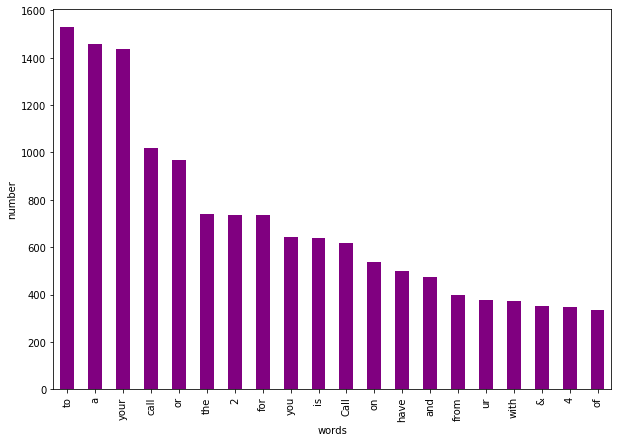

In [112]:
spam_words = Counter(" ".join(data[data['target']=='spam']['text']).split()).most_common(20)
df_spam_words = pd.DataFrame.from_dict(spam_words)
df_spam_words = df_spam_words.rename(columns={0: "words of spam", 1 : "count"})
df_ham_words.plot.bar(legend = False, color = 'purple',figsize = (10,7))
y_pos = np.arange(len(df_spam_words["words of spam"]))
plt.xticks(y_pos, df_spam_words["words of spam"])
plt.xlabel('words')
plt.ylabel('number')
plt.show()

<h3> П4. Выполнить токенизацию текстового признака, исключив неинформативные часто встречающиеся слова.</h3>

Текст — это набор токенов. Токенизация – это преобразование текста в признаковый вектор,отражающий информационное содержание письма.


In [113]:
tokenizer = feature_extraction.text.CountVectorizer(stop_words = 'english') 
X = tokenizer.fit_transform(data['text']) 


<h3> П5. Найти оптимальный параметр сглаживания alpha для наивного байесовского классификатора по метрикам precision и accuracy. </h3>

![Ttile](https://imgur.com/ngtAWFV.png)
P(A|B) - вероятность, что слово В принадлежит к классу А(spam).

P(B|A) - вероятность встретить слово В в классе А(spam).

P(A) - вероятность встретить класс А среди всех текстов.

P(B) - вероятность встретить слово В среди всех текстов.

НБА предполагает, что наличие какого-либо признака в классе не связано с наличием какого-либо другого признака. Цель классификации - понять к какому классу принадлежит слово, поэтому нужна не сама вероятность, а наиболее вероятный класс.  
![Ttile](https://imgur.com/dJqfWDv.png)
вхождение слова Xi в документ класса Qk:
![Ttile](https://imgur.com/CfFpJlY.png)
Nk - количество слов входящих в текст класса Qk

M - количество слов из обучающей выборки

Nik - количество вхождений слова Xi в текст класса Qk 

a-сглаживающий параметр (чтобы значения логарифмируемых вероятностей были не слишком близки к 0, например при незнакомых словах(нет в словаре) в тексте).

Multinomial (мультиномиальное распределение). Используется в случае дискретных признаков. Признаки могут показывать, сколько раз каждое слово встречается в данном тексте.


In [114]:
data['target'] = data['target'].map({'spam':1, 'ham':0}) 
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['target'], test_size = 0.33) 
alpha_range = np.arange(0.1, 20, 0.1) 
accuracy=[]
accuracy_train=[]
recall=[]
precision=[]
for alpha in alpha_range:
    mnb = MultinomialNB(alpha = alpha)
    mnb.fit(X_train,y_train)
    y_mnb = mnb.predict(X_test)
    y_mnb_train = mnb.predict(X_train)
    accuracy.append(metrics.accuracy_score(y_test,y_mnb))
    accuracy_train.append(metrics.accuracy_score( y_train,y_mnb_train))
    recall.append(metrics.recall_score( y_test,y_mnb))
    precision.append(metrics.precision_score( y_test,y_mnb))

matrix  =  np.matrix(np.c_[alpha_range,accuracy_train,accuracy ,recall,precision]) 
models = pd.DataFrame(data = matrix,  columns =  ['alpha', 'train accuracy',  'test accuracy',
'test recall','test precision']) 
best_index = models['test precision'].idxmax() 
best_value=models['test precision'][best_index]
print(best_value)
best_index = models[models['test precision']==best_value]['test accuracy'].idxmax() 
model = MultinomialNB(alpha = alpha_range[best_index]) 
model.fit(X_train, y_train)


1.0


MultinomialNB(alpha=10.0)

<h3> П6. Построить зависимость метрики accuracy на обучающих и тестовых
данных от варьируемого параметра. Построить матрицы ошибок для
модели с оптимальным выбранным параметром. </h3>

Text(0, 0.5, 'metric')

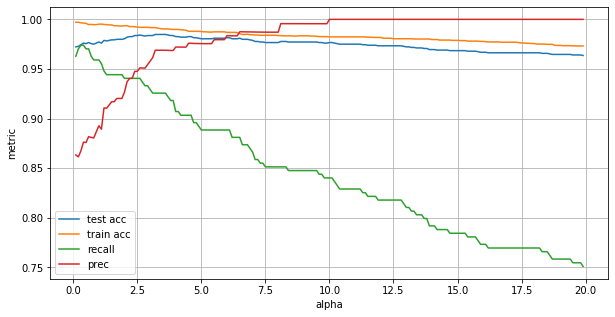

In [115]:
plt.figure(figsize = [10,5])
plt.plot(alpha_range, accuracy)
plt.plot(alpha_range, accuracy_train)
plt.plot(alpha_range, recall)
plt.plot(alpha_range, precision)
plt.legend(['test acc','train acc','recall','prec'])
plt.grid('on')
plt.xlabel('alpha')
plt.ylabel('metric')

Матрица показывает сколько объектов класса i были распознаны как объекты класса j. 

True Positive (истинно-положительное решение): прогноз совпал с реальностью, результат положительный произошел, как и было предсказано ML-моделью.

False Positive (ложноположительное решение): ошибка 1-го рода, ML-модель предсказала положительный результат, а на самом деле он отрицательный.

False Negative (ложноотрицательное решение): ошибка 2-го рода – ML-модель предсказала отрицательный результат, но на самом деле он положительный.

True Negative (истинно-отрицательное решение): результат отрицательный, ML-прогноз совпал с реальностью.

![Ttile](https://imgur.com/UYDKwNd.png)

Accuracy = (TP+TN)/(TP+FP+FN+TN) - процент правильно классифицированных объектов.

Precision = TP/(TP+FP) - процент правильно классифицированных объектов класса 1 среди всех объектов, которым алгоритм присвоил класс 1.

Recall = TP/(TP+FN) - процент правильно классифицированных объектов класса 1 среди всех объектов класса 1.

F1 = 2* precision*recall/(precision+recall)


In [116]:
confusion_matrix = confusion_matrix(y_test, model.predict(X_test)) 
pd.DataFrame(data  =  confusion_matrix,  columns  =  ['predicted  ham', 
'predicted spam'], index = ['actual ham', 'actual spam']) 

,predicted ham,predicted spam
actual ham,1570,0
actual spam,43,226


<h3> П7.Построить ROC-кривую и рассчитать метрику AUC-ROC.</h3>

Результат визуализируем с помощью ROC-кривой(кривая ошибок), а качество- как площадь под этой кривой – AUC. Используют для оценивания качества упорядочивания алгоритмом объектов двух классов.

ROC график, показывает зависимость верно классифицируемых объектов положительного класса от ложно положительно классифицируемых объектов негативного класса

По оси X отложена доля ошибочных положительных классификаций (False Positive Rate)

Gо оси Y – доля правильных положительных классификаций(True Positive Rate) или Recall, которую мы хотим максимизировать.

AUC равен доле пар объектов вида (объект класса 1, объект класса 0), которые алгоритм верно упорядочил (объект класса 1 получил оценку выше, чем объект класса 0, т.е вероятность класса 1 быть распознанным как класс 1 выше, чем как класс 0)

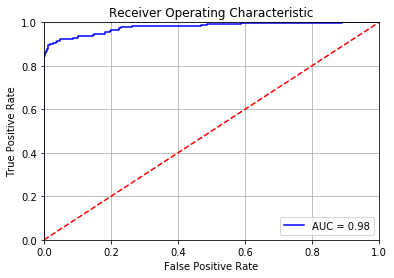

In [117]:
y_pred_pr = model.predict_proba(X_test)[:,1] 
fpr, tpr, threshold = metrics. roc_curve (y_test, y_pred_pr) 
roc_auc = metrics.auc(fpr, tpr) 
plt.title('Receiver Operating Characteristic') 
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc) 
plt.legend(loc = 'lower right') 
plt.plot([0, 1], [0, 1],'r--') 
plt.xlim([0, 1]) 
plt.ylim([0, 1]) 
plt.ylabel('True Positive Rate') 
plt.xlabel('False Positive Rate') 
plt.grid('on') 
plt.show() 

<h3> П8. Найти оптимальный параметр регуляризатора С для модели опорных векторов по метрикам precision и accuracy.</h3> 

Задача SVM максимизировать зазор, разделяющий классы. Ширина зазора считается по формуле:
![Ttile](https://imgur.com/QM9UHgm.png)

Если выборка линейно не разделима, то нужно ввести штраф С, который штрафует объекты за приближение к границе классов, увеличивая зазор между классами. 
![Ttile](https://imgur.com/o5foOXa.png)

In [123]:

SVC_precision=[]
SVC_accuracy=[]
SVC_train_accuracy=[]
SVC_recall=[]
c_range= np.arange(0.1, 3, 0.1)
for c in c_range:
    svc = SVC(C=c)
    svc.fit(X_train, y_train)
    Y_predict = svc.predict(X_test)
    Y_train_predict = svc.predict(X_train)
    SVC_accuracy.append(metrics.accuracy_score(y_test,Y_predict))
    SVC_precision.append(metrics.precision_score(y_test,Y_predict))
    SVC_train_accuracy.append(metrics.accuracy_score(y_train,Y_train_predict))
    SVC_recall.append(metrics.recall_score(y_test,Y_predict))
    с_ranges.append(c)

SVC_matrix  =  np.matrix(np.c_[c_range,SVC_train_accuracy,SVC_accuracy ,SVC_recall,SVC_precision]) 
SVC_models = pd.DataFrame(data = SVC_matrix,  columns =  ['C', 'train accuracy',  'test accuracy',
'test recall','test precision']) 
SVC_best_index = SVC_models['test precision'].idxmax() 
SVC_best_value=SVC_models['test precision'][SVC_best_index]
print(SVC_best_value)
SVC_best_index = SVC_models[SVC_models['test precision']==SVC_best_value]['test accuracy'].idxmax() 
SVC_model = SVC(C = c_range[SVC_best_index],probability = True) 
SVC_model.fit(X_train, y_train)


C:\Games\Anaconda1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0


SVC(C=1.8000000000000003, probability=True)

<h3> П6. Для SVC. Построить зависимость метрики accuracy на обучающих и тестовых
данных от варьируемого параметра. Построить матрицы ошибок для
модели с оптимальным выбранным параметром.</h3> 


TypeError: 'numpy.ndarray' object is not callable

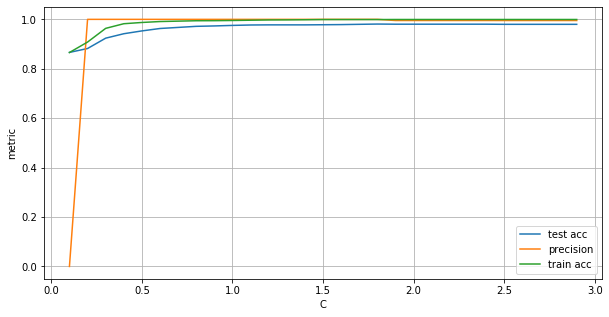

In [124]:
plt.figure(figsize = [10,5])
plt.plot(c_range, SVC_accuracy)
plt.plot(c_range, SVC_precision)
plt.plot(c_range, SVC_train_accuracy)
plt.legend(['test acc','precision','train acc'])
plt.grid('on')
plt.xlabel('C')
plt.ylabel('metric')
SVC_confusion_matrix = confusion_matrix(y_test, SVC_model.predict(X_test)) 
pd.DataFrame(data  =  SVC_confusion_matrix,  columns  =  ['predicted  ham', 
'predicted spam'], index = ['actual ham', 'actual spam']) 

<h3> П7. Для SVC. Построить ROC-кривую и рассчитать метрику AUC-ROC.</h3>

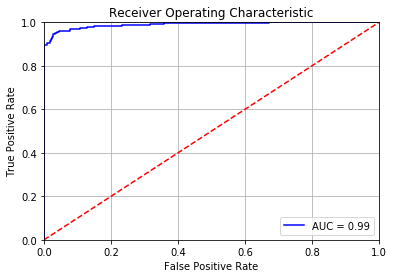

In [125]:
y_pred_pr = SVC_model.predict_proba(X_test)[:,1] 
fpr, tpr, threshold = metrics. roc_curve (y_test, y_pred_pr) 
roc_auc = metrics.auc(fpr, tpr) 
plt.title('Receiver Operating Characteristic') 
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc) 
plt.legend(loc = 'lower right') 
plt.plot([0, 1], [0, 1],'r--') 
plt.xlim([0, 1]) 
plt.ylim([0, 1]) 
plt.ylabel('True Positive Rate') 
plt.xlabel('False Positive Rate') 
plt.grid('on') 
plt.show() 

<h3>Вывод.</h3> 
В работе я ознакомился с метриками accuracy, precision и recall, по ним были выбраны лучшие параметры для MNB и SVC классификаторов, построил матрицы ошибок и AUC-ROC диаграммы.

